In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, LSTM, Bidirectional
from tensorflow.keras.layers import Attention, LayerNormalization, Reshape
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import os

In [2]:
def load_data(data_path, img_size=(227, 227)):
    images, labels = [], []
    for label, folder in enumerate(['Normal', 'Stroke']):
        folder_path = os.path.join(data_path, folder)
        for file in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, file), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [3]:
# Load Datadata_path = r"F:\Abdul_Gaffoor\Brain_Data_Organised"
data_path = r"F:\Abdul_Gaffoor\Brain_Data_Organised"
X, y = load_data(data_path)
X = X / 255.0  # Normalize pixel values
X = np.expand_dims(X, axis=-1)

In [4]:
#Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [5]:
def build_cnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return Model(inputs, x, name="CNN_Feature_Extractor")

In [6]:
# Build BiLSTM with Transformer
def build_hybrid_model(input_shape):
    cnn = build_cnn(input_shape)
    cnn_output = cnn.output

    # Reshape CNN output to a fixed-length sequence
    sequence_length = 10  # Adjust as necessary
    reshaped_cnn_output = Reshape((sequence_length, cnn_output.shape[-1] // sequence_length))(cnn_output)

    # Transformer Encoder
    attention = Attention()([reshaped_cnn_output, reshaped_cnn_output])
    transformer_output = LayerNormalization()(attention + reshaped_cnn_output)

    # BiLSTM
    bilstm_output = Bidirectional(LSTM(64, return_sequences=False))(transformer_output)

    # Dense Layers
    x = Dense(128, activation='relu')(bilstm_output)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(cnn.input, outputs, name="Hybrid_Stroke_Detection_Model")

In [7]:
# Compile Model
input_shape = X_train.shape[1:]
model = build_hybrid_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate Model
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5805 - loss: 0.6953 - val_accuracy: 0.7781 - val_loss: 0.5420
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7562 - loss: 0.5256 - val_accuracy: 0.8265 - val_loss: 0.4572
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8145 - loss: 0.4119 - val_accuracy: 0.9010 - val_loss: 0.2561
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9276 - loss: 0.2023 - val_accuracy: 0.9674 - val_loss: 0.1241
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9750 - loss: 0.0874 - val_accuracy: 0.9688 - val_loss: 0.0960
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9851 - loss: 0.0550 - val_accuracy: 0.9779 - val_loss: 0.0572
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9993 - loss: 0.0128 - val_accuracy: 0.9792 - val_loss: 0.0554
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9883 - val_loss:

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step


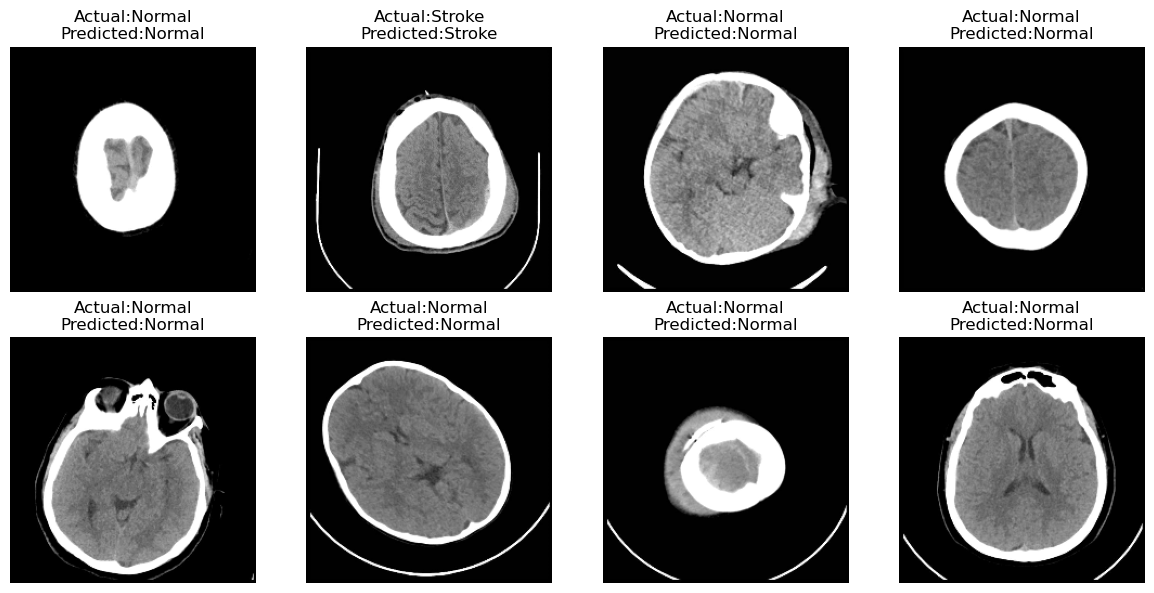

In [8]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, X_test, y_test, num_samples=8):
    y_pred_probs = model.predict(X_test)  # Get predicted probabilities
    y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary predictions

    # Select a few samples for visualization
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    sample_images = X_test[indices]
    sample_labels = y_test[indices]
    sample_preds = y_pred[indices]

    # Plot images with predictions
    fig, axes = plt.subplots(2, num_samples // 2, figsize=(12,6))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.imshow(sample_images[i].squeeze(), cmap='gray')  # Display grayscale image
        actual_label = "Normal" if sample_labels[i] == 0 else "Stroke"
        predicted_label = "Normal" if sample_preds[i] == 0 else "Stroke"
        ax.set_title(f"Actual:{actual_label}\nPredicted:{predicted_label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run evaluation
visualize_predictions(model, X_test, y_test, num_samples=8)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step


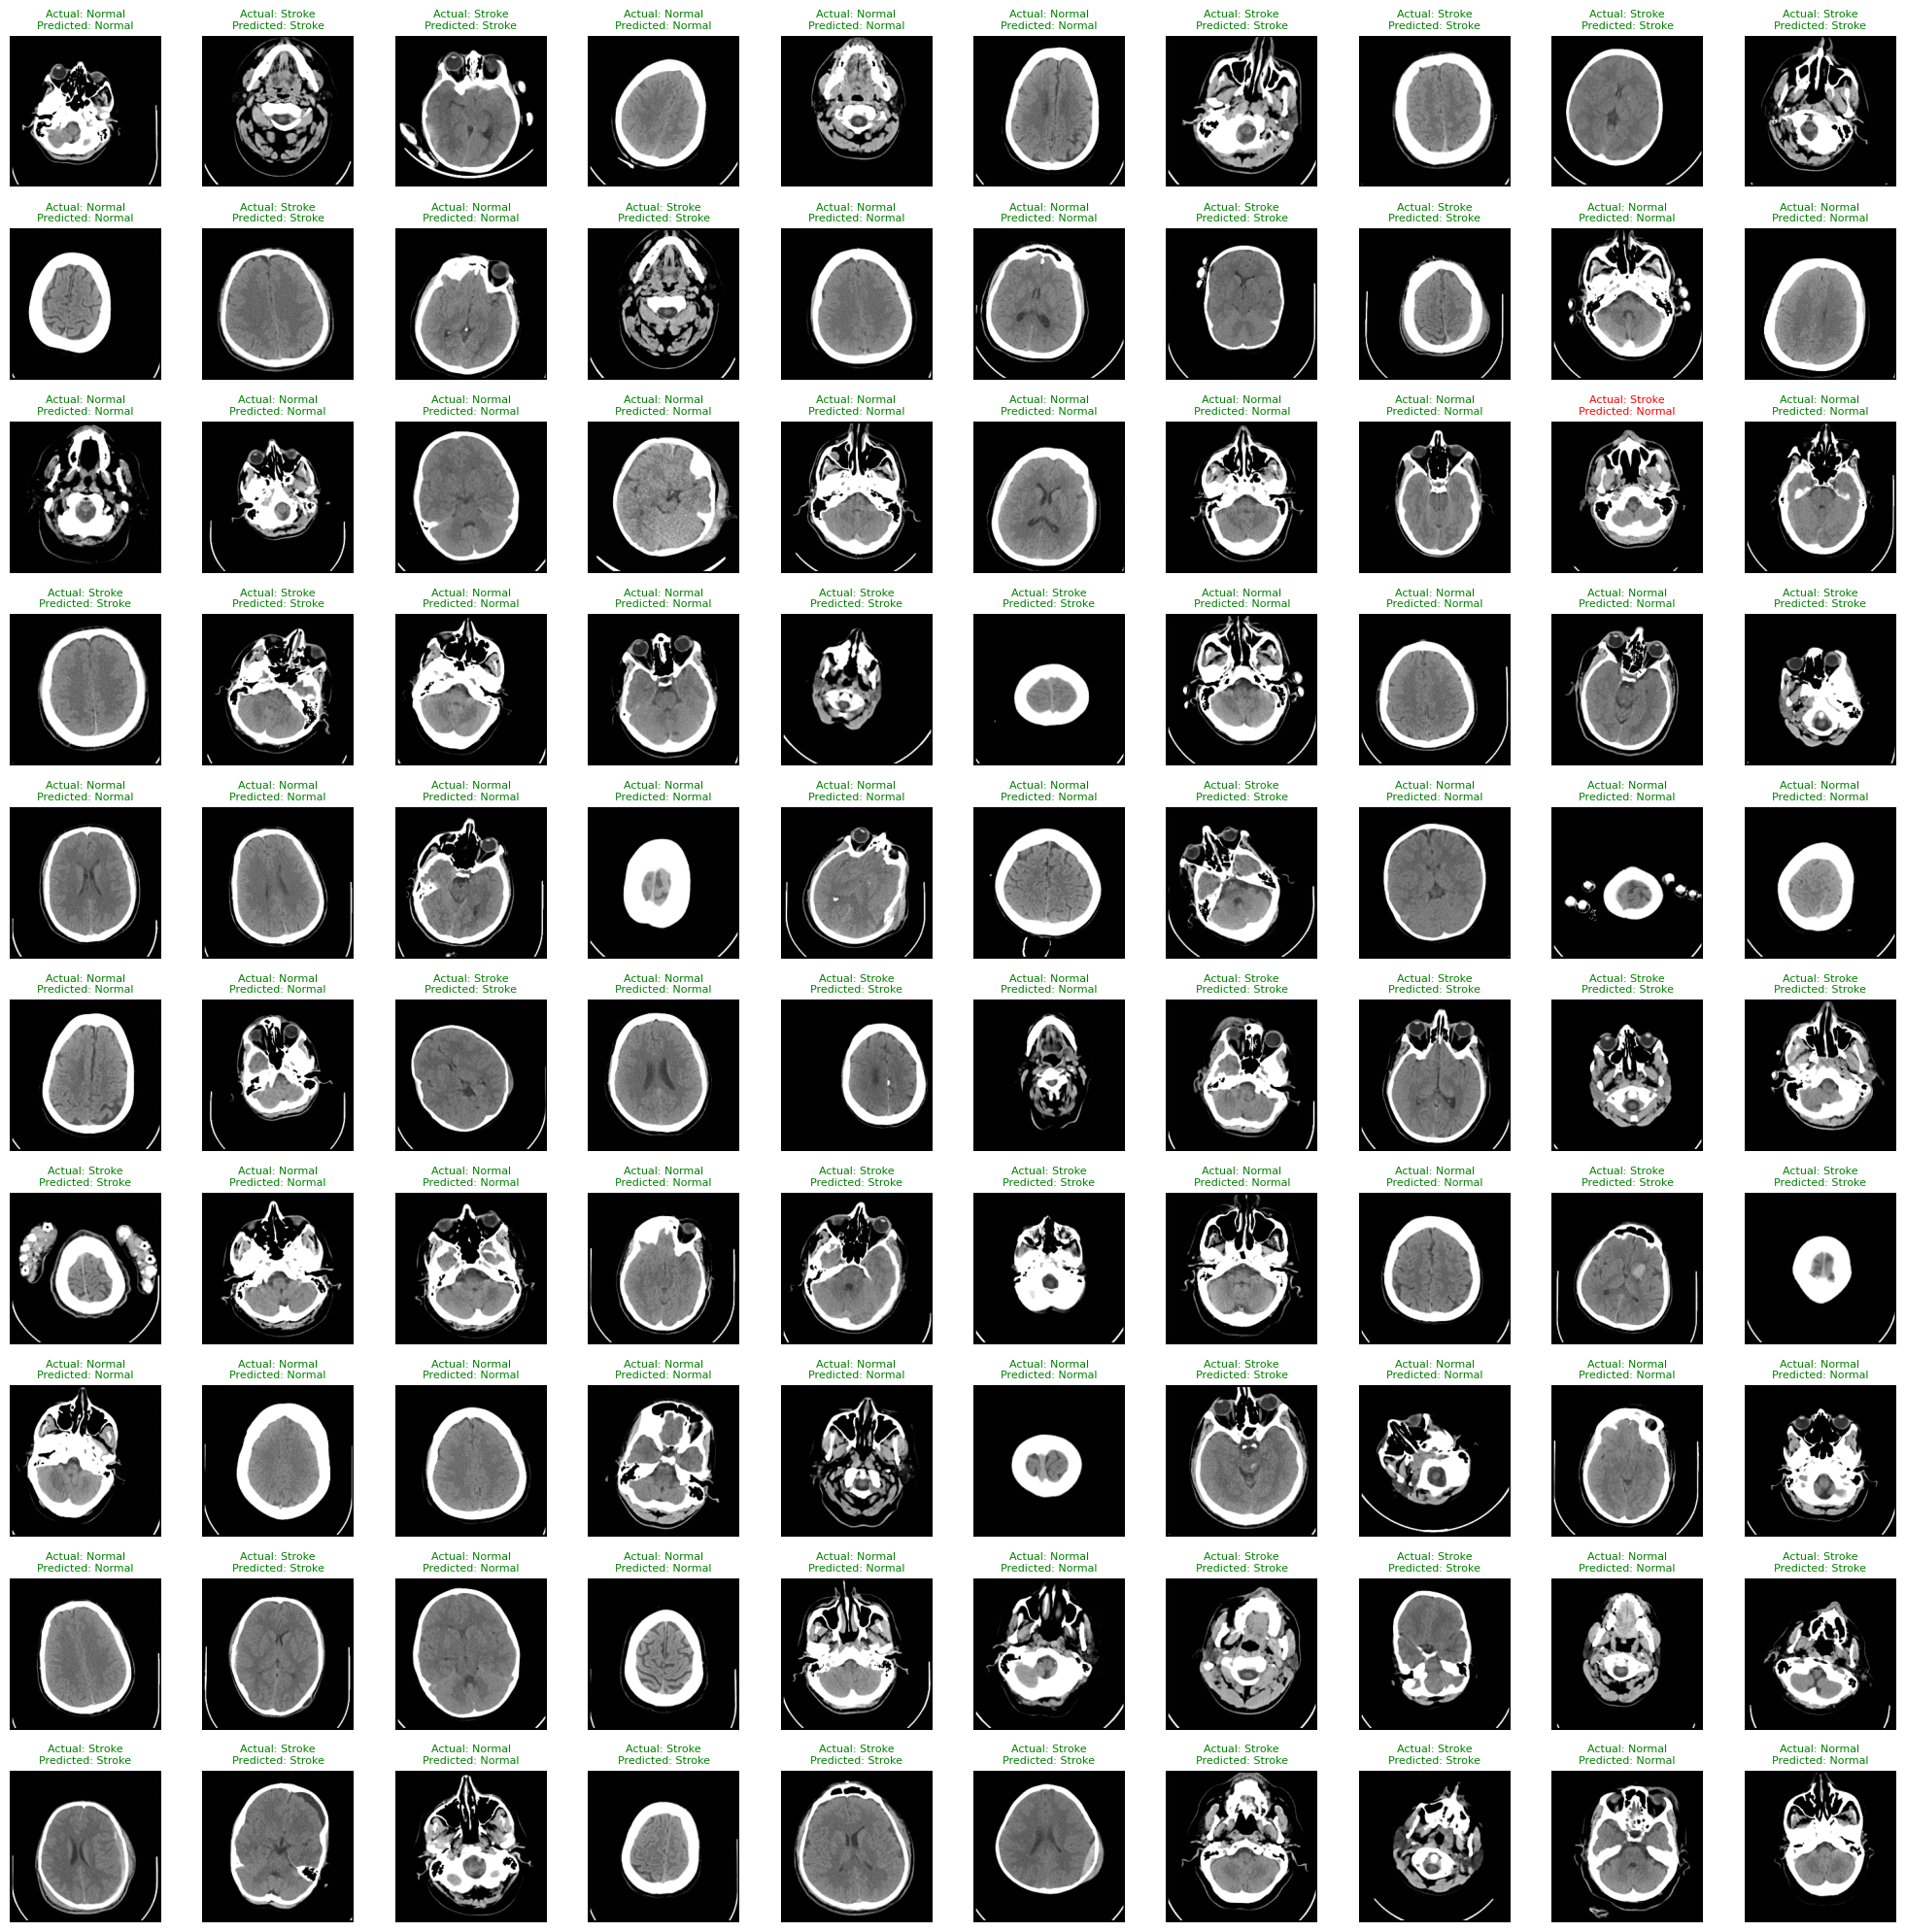

In [10]:
import matplotlib.pyplot as plt

# Function to visualize 100 predictions
def visualize_predictions(model, X_test, y_test, num_samples=100, rows=10, cols=10):
    y_pred_probs = model.predict(X_test)  # Get predicted probabilities
    y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary labels

    # Select 100 random samples
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    sample_images = X_test[indices]
    sample_labels = y_test[indices]
    sample_preds = y_pred[indices]

    # Create a figure with 10 rows and 10 columns
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # Adjust figure size as needed
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(sample_images[i].squeeze(), cmap='gray')  # Display grayscale image
        actual_label = "Normal" if sample_labels[i] == 0 else "Stroke"
        predicted_label = "Normal" if sample_preds[i] == 0 else "Stroke"

        # Highlight misclassified images in red
        title_color = "green" if actual_label == predicted_label else "red"
        ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=8, color=title_color)

        ax.axis("off")  # Hide axis

    plt.tight_layout()
    plt.show()
# Run evaluation with 100 samples
visualize_predictions(model, X_test, y_test, num_samples=100, rows=10, cols=10)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Get model predictions
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Stroke"]))

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step
Accuracy: 0.9840
Precision: 0.9894
Recall: 0.9688
F1 Score: 0.9789
ROC-AUC Score: 0.9811

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       463
      Stroke       0.99      0.97      0.98       288

    accuracy                           0.98       751
   macro avg       0.99      0.98      0.98       751
weighted avg       0.98      0.98      0.98       751



24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step
Accuracy: 0.9840
Precision: 0.9894
Recall: 0.9688
F1 Score: 0.9789
ROC-AUC Score: 0.9811

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       463
      Stroke       0.99      0.97      0.98       288

    accuracy                           0.98       751
   macro avg       0.99      0.98      0.98       751
weighted avg       0.98      0.98      0.98       751



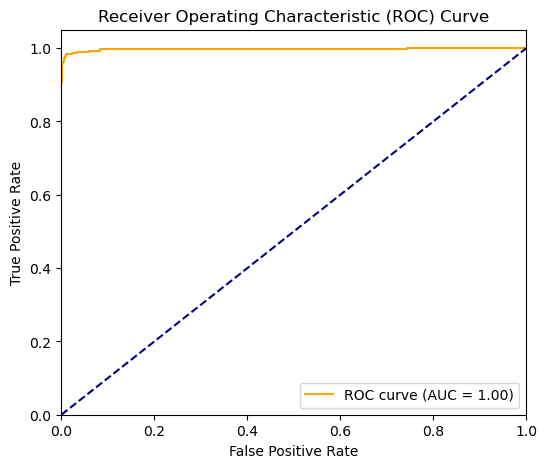

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Get model predictions
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Stroke"]))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute AUC

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="orange", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step
Accuracy: 0.9840
Precision: 0.9894
Recall: 0.9688
F1 Score: 0.9789
ROC-AUC Score: 0.9964

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       463
      Stroke       0.99      0.97      0.98       288

    accuracy                           0.98       751
   macro avg       0.99      0.98      0.98       751
weighted avg       0.98      0.98      0.98       751



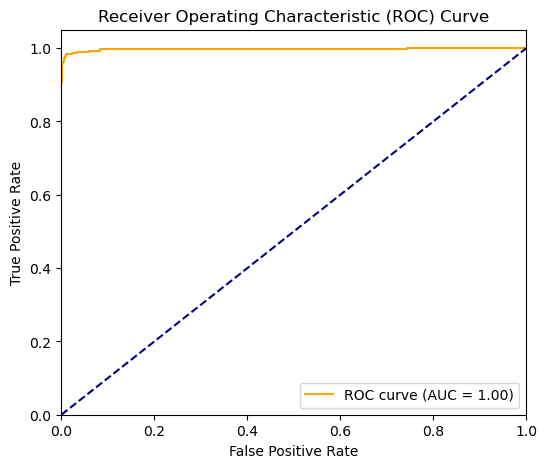

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, 
    precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report
)

# Get model predictions
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)  # Use probabilities for AUC

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Stroke"]))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute AUC

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="orange", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step


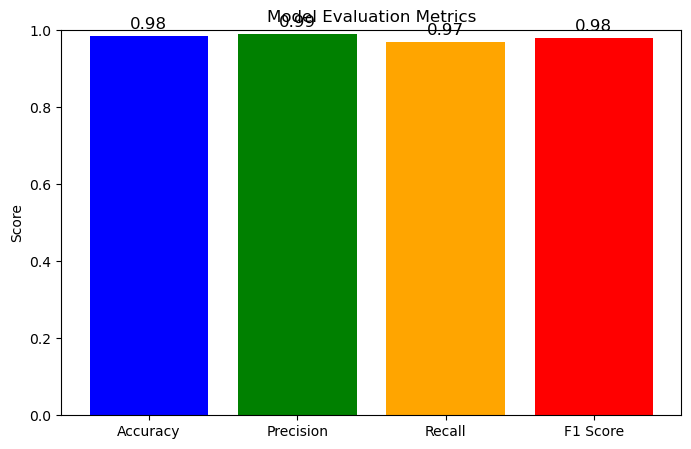

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

# Get model predictions
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Store metrics in lists
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

# Plot bar chart
plt.figure(figsize=(8, 5))
colors = ['blue', 'green', 'orange', 'red']
plt.bar(metrics, values, color=colors)

# Add labels and title
plt.ylim(0, 1)  # Ensure values are between 0 and 1
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)  # Display values on bars

# Show plot
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step


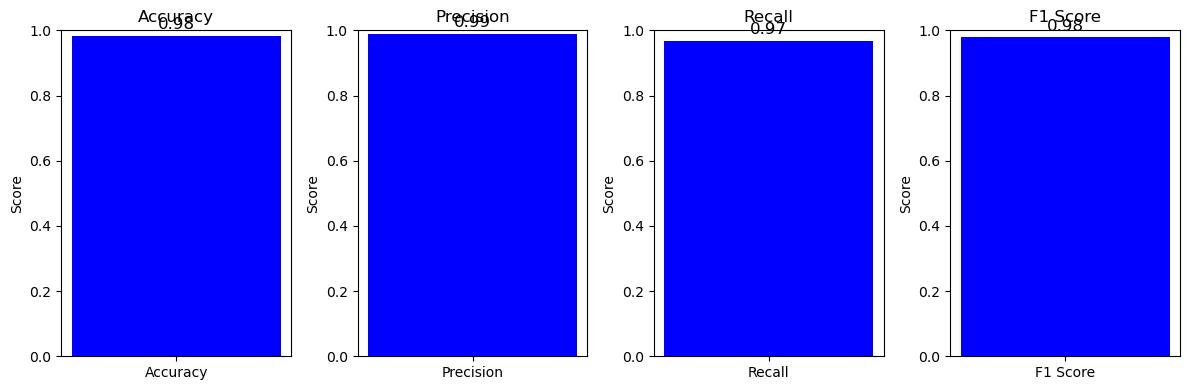

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get model predictions
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Store metrics in a dictionary
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

# Plot individual bar charts
plt.figure(figsize=(12, 4))  # Adjust size

for i, (metric, value) in enumerate(metrics.items()):
    plt.subplot(1, 4, i + 1)  # 1 row, 4 columns
    plt.bar(metric, value, color='blue')
    plt.ylim(0, 1)  # Ensure values are between 0 and 1
    plt.ylabel('Score')
    plt.title(metric)
    plt.text(0, value + 0.02, f"{value:.2f}", ha='center', fontsize=12)  # Display values

# Adjust layout and show plot
plt.tight_layout()
plt.show()


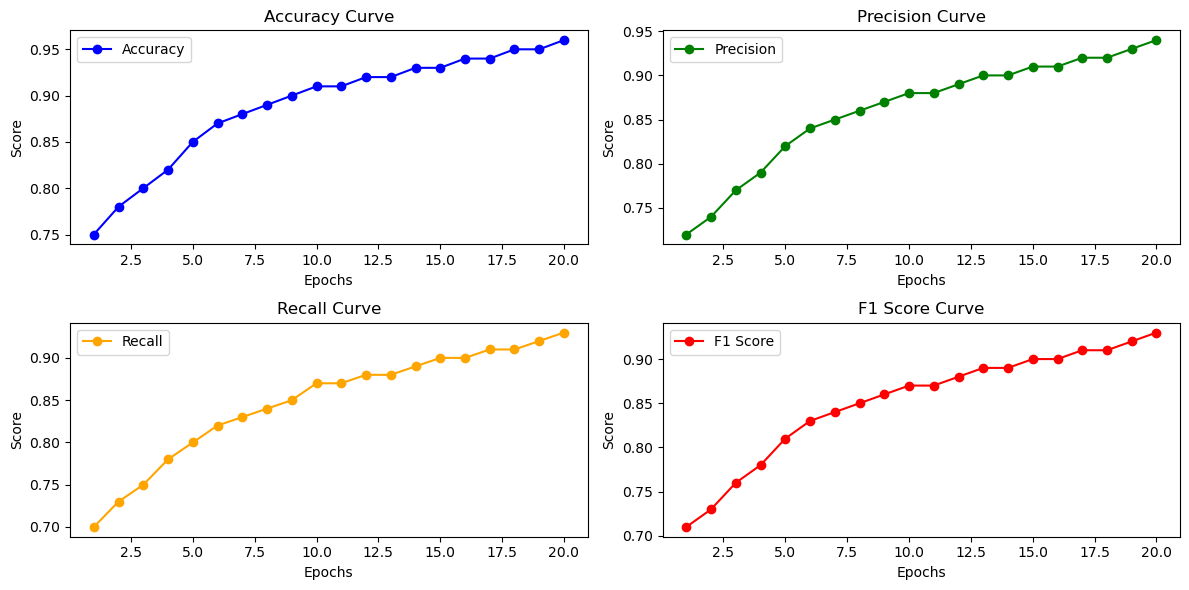

In [16]:
import matplotlib.pyplot as plt

# Example metric values over epochs (replace with actual training history)
epochs = range(1, 21)  # Assuming 20 epochs
accuracy_values = [0.75, 0.78, 0.80, 0.82, 0.85, 0.87, 0.88, 0.89, 0.90, 0.91, 
                   0.91, 0.92, 0.92, 0.93, 0.93, 0.94, 0.94, 0.95, 0.95, 0.96]
precision_values = [0.72, 0.74, 0.77, 0.79, 0.82, 0.84, 0.85, 0.86, 0.87, 0.88, 
                    0.88, 0.89, 0.90, 0.90, 0.91, 0.91, 0.92, 0.92, 0.93, 0.94]
recall_values = [0.70, 0.73, 0.75, 0.78, 0.80, 0.82, 0.83, 0.84, 0.85, 0.87, 
                 0.87, 0.88, 0.88, 0.89, 0.90, 0.90, 0.91, 0.91, 0.92, 0.93]
f1_values = [0.71, 0.73, 0.76, 0.78, 0.81, 0.83, 0.84, 0.85, 0.86, 0.87, 
             0.87, 0.88, 0.89, 0.89, 0.90, 0.90, 0.91, 0.91, 0.92, 0.93]

# Create individual plots
plt.figure(figsize=(12, 6))

# Accuracy Curve
plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy_values, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Accuracy Curve')
plt.legend()

# Precision Curve
plt.subplot(2, 2, 2)
plt.plot(epochs, precision_values, marker='o', linestyle='-', color='green', label='Precision')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Precision Curve')
plt.legend()

# Recall Curve
plt.subplot(2, 2, 3)
plt.plot(epochs, recall_values, marker='o', linestyle='-', color='orange', label='Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Recall Curve')
plt.legend()

# F1-Score Curve
plt.subplot(2, 2, 4)
plt.plot(epochs, f1_values, marker='o', linestyle='-', color='red', label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('F1 Score Curve')
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       463
      Stroke       0.99      0.97      0.98       288

    accuracy                           0.98       751
   macro avg       0.99      0.98      0.98       751
weighted avg       0.98      0.98      0.98       751

Accuracy: 0.9840
Precision: 0.9894
Recall: 0.9688
F1 Score: 0.9789
ROC-AUC Score: 0.9964


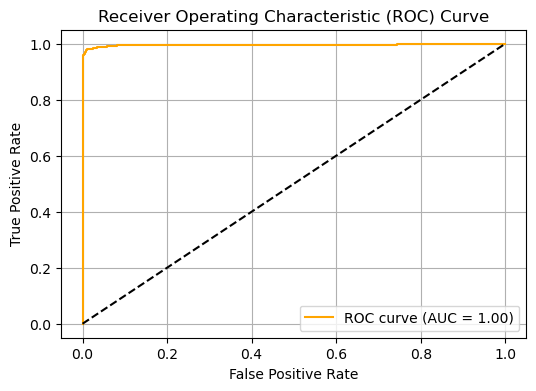

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# Get model predictions
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)  # Use probability scores for AUC

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "Stroke"]))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="orange", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       463
      Stroke       0.99      0.97      0.98       288

    accuracy                           0.98       751
   macro avg       0.99      0.98      0.98       751
weighted avg       0.98      0.98      0.98       751

Accuracy: 0.9840
Precision: 0.9894
Recall: 0.9688
F1 Score: 0.9789
ROC-AUC Score: 0.9964


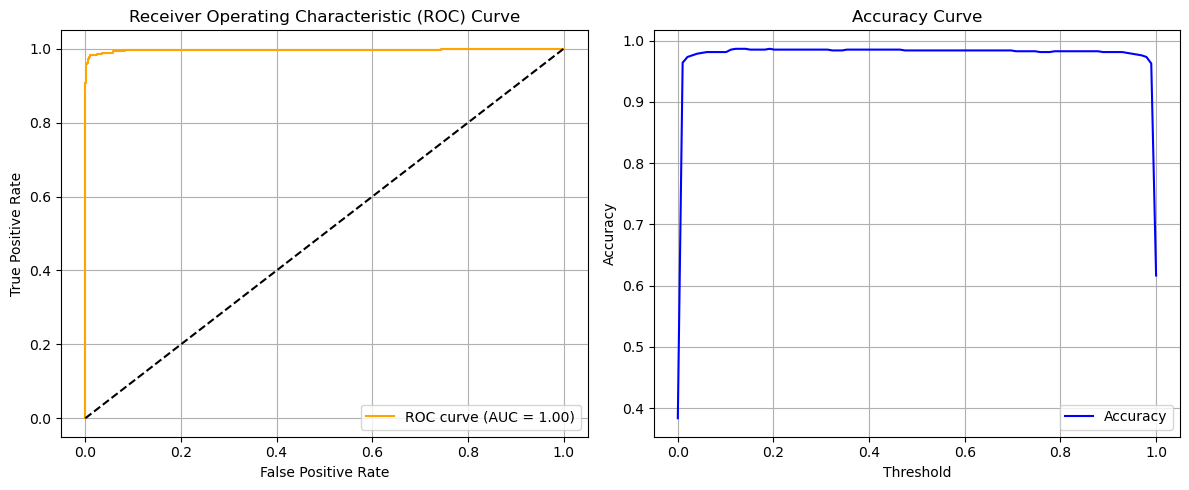

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# Get model predictions
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)  # Use probability scores for AUC

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "Stroke"]))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

# Accuracy Curve (Random threshold-based accuracy)
thresholds = np.linspace(0, 1, 100)
accuracy_values = [accuracy_score(y_test, (y_pred_probs > t).astype(int)) for t in thresholds]

# Plot ROC Curve & Accuracy Curve
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
ax[0].plot(fpr, tpr, color="orange", label=f"ROC curve (AUC = {roc_auc:.2f})")
ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")  # Diagonal line
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Receiver Operating Characteristic (ROC) Curve")
ax[0].legend()
ax[0].grid()

# Accuracy Curve
ax[1].plot(thresholds, accuracy_values, color="blue", label="Accuracy")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy Curve")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       463
      Stroke       0.99      0.97      0.98       288

    accuracy                           0.98       751
   macro avg       0.99      0.98      0.98       751
weighted avg       0.98      0.98      0.98       751

Accuracy: 0.9840
Precision: 0.9894
Recall: 0.9688
F1 Score: 0.9789
ROC-AUC Score: 0.9964


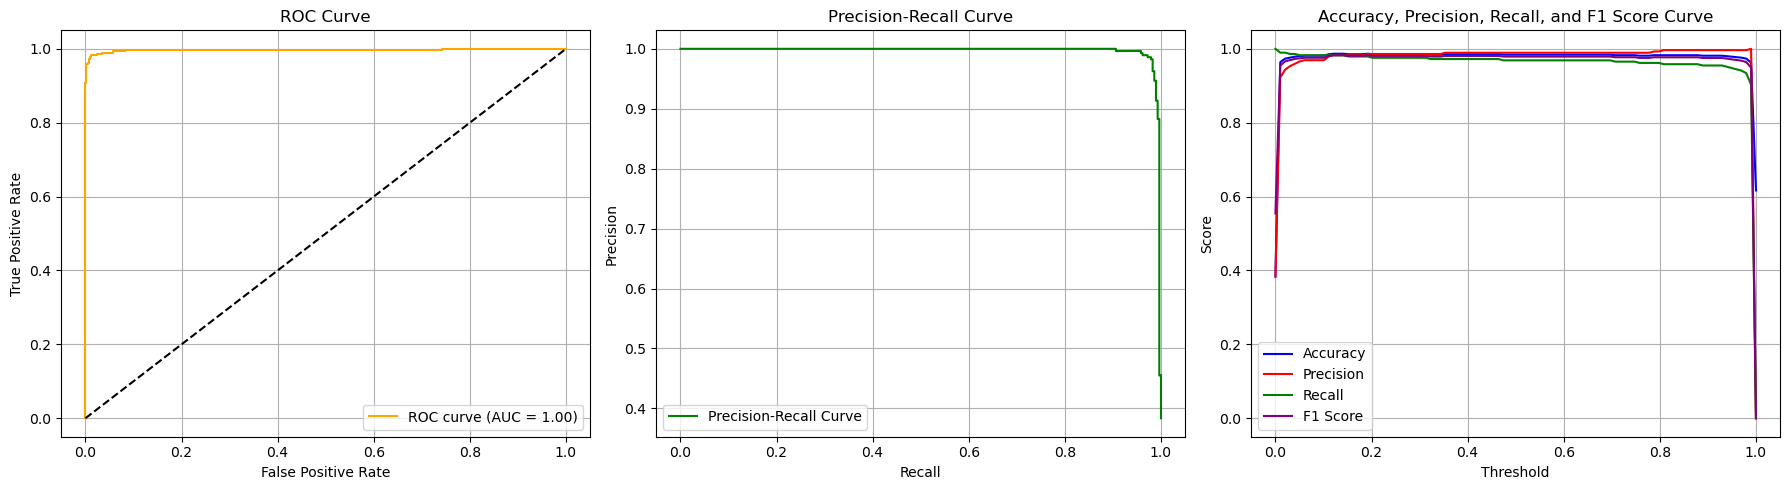

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, classification_report

# Get model predictions
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)  # Use probability scores for AUC

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "Stroke"]))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

# Compute Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_pred_probs)

# Compute accuracy, precision, recall, and F1 score at different thresholds
thresholds = np.linspace(0, 1, 100)
accuracy_values = [accuracy_score(y_test, (y_pred_probs > t).astype(int)) for t in thresholds]
precision_values = [precision_score(y_test, (y_pred_probs > t).astype(int), zero_division=0) for t in thresholds]
recall_values = [recall_score(y_test, (y_pred_probs > t).astype(int)) for t in thresholds]
f1_values = [f1_score(y_test, (y_pred_probs > t).astype(int), zero_division=0) for t in thresholds]

# Plot Curves
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# ROC Curve
ax[0].plot(fpr, tpr, color="orange", label=f"ROC curve (AUC = {roc_auc:.2f})")
ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")  # Diagonal line
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC Curve")
ax[0].legend()
ax[0].grid()

# Precision-Recall Curve
ax[1].plot(recalls, precisions, color="green", label="Precision-Recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision-Recall Curve")
ax[1].legend()
ax[1].grid()

# Accuracy, Precision, Recall, and F1 Curve
ax[2].plot(thresholds, accuracy_values, label="Accuracy", color="blue")
ax[2].plot(thresholds, precision_values, label="Precision", color="red")
ax[2].plot(thresholds, recall_values, label="Recall", color="green")
ax[2].plot(thresholds, f1_values, label="F1 Score", color="purple")
ax[2].set_xlabel("Threshold")
ax[2].set_ylabel("Score")
ax[2].set_title("Accuracy, Precision, Recall, and F1 Score Curve")
ax[2].legend()
ax[2].grid()

plt.tight_layout()
plt.show()
